**Packages**

In [36]:
import numpy as np
import pandas as pd
import math

import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate
import tensorflow_addons as tfa
import tifffile

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os

import scipy

**Helper Functions**

In [46]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()
    plt.grid(True)

In [47]:
def plot_accuracy(history):
   # plt.plot(history.history['loss'], label='loss')
   # plt.plot(history.history['val_loss'], label='val_loss')
    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['accuracy']),
                max(history.history['val_accuracy'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()
    plt.grid(True)

In [48]:
def plot_f1(history):
    plt.plot(history.history['f1'], label='train_f1')
    plt.plot(history.history['val_f1'], label='val_f1')
    plt.ylim([0, 
            max(
                max(history.history['f1']),
                max(history.history['val_f1'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.title('F1 Score')
    plt.legend()
    plt.grid(True)

In [24]:
# FROM https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py

kaiming_normal = keras.initializers.VarianceScaling(scale=2.0, mode='fan_out', distribution='untruncated_normal')

def conv3x3(x, out_planes, stride=1, name=None):
    x = layers.ZeroPadding2D(padding=1, name=f'{name}_pad')(x)
    return layers.Conv2D(filters=out_planes, kernel_size=3, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=name)(x)

def basic_block(x, planes, stride=1, downsample=None, name=None):
    identity = x

    out = conv3x3(x, planes, stride=stride, name=f'{name}.conv1')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn1')(out)
    out = layers.ReLU(name=f'{name}.relu1')(out)

    out = conv3x3(out, planes, name=f'{name}.conv2')
    out = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.bn2')(out)

    if downsample is not None:
        for layer in downsample:
            identity = layer(identity)

    out = layers.Add(name=f'{name}.add')([identity, out])
    out = layers.ReLU(name=f'{name}.relu2')(out)

    return out

def make_layer(x, planes, blocks, stride=1, name=None):
    downsample = None
    inplanes = x.shape[3]
    if stride != 1 or inplanes != planes:
        downsample = [
            layers.Conv2D(filters=planes, kernel_size=1, strides=stride, use_bias=False, kernel_initializer=kaiming_normal, name=f'{name}.0.downsample.0'),
            layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name=f'{name}.0.downsample.1'),
        ]

    x = basic_block(x, planes, stride, downsample, name=f'{name}.0')
    for i in range(1, blocks):
        x = basic_block(x, planes, name=f'{name}.{i}')

    return x

def resnet(x, blocks_per_layer, num_classes=1000):
    x = layers.ZeroPadding2D(padding=3, name='conv1_pad')(x)
    x = layers.Conv2D(filters=64, kernel_size=7, strides=2, use_bias=False, kernel_initializer=kaiming_normal, name='conv1')(x)
    x = layers.BatchNormalization(momentum=0.9, epsilon=1e-5, name='bn1')(x)
    x = layers.ReLU(name='relu1')(x)
    x = layers.ZeroPadding2D(padding=1, name='maxpool_pad')(x)
    x = layers.MaxPool2D(pool_size=3, strides=2, name='maxpool')(x)

    x = make_layer(x, 64, blocks_per_layer[0], name='layer1')
    x = make_layer(x, 128, blocks_per_layer[1], stride=2, name='layer2')
    x = make_layer(x, 256, blocks_per_layer[2], stride=2, name='layer3')
    x = make_layer(x, 512, blocks_per_layer[3], stride=2, name='layer4')

    x = layers.GlobalAveragePooling2D(name='avgpool')(x)
    initializer = keras.initializers.RandomUniform(-1.0 / math.sqrt(512), 1.0 / math.sqrt(512))
    x = layers.Dense(units=num_classes, kernel_initializer=initializer, bias_initializer=initializer, name='fc')(x)

    return x

def resnet18(x, **kwargs):
    return resnet(x, [2, 2, 2, 2], **kwargs)

def resnet34(x, **kwargs):
    return resnet(x, [3, 4, 6, 3], **kwargs)

**Data Pre-Processing**

Pulling in Train and Test Sets

In [25]:
tiles_train = pd.read_csv(r'./Data/Tiles_TRAIN.csv')
x_train = tiles_train.drop(['Tile_ID', 'bins_numeric'], axis = 1)
y_train = tiles_train['bins_numeric']
x_train.head(5)

,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,2.0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1.0,0.0,1.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
tiles_test = pd.read_csv(r'./Data/Tiles_TEST.csv')
x_test = tiles_test.drop(['Tile_ID','bins_numeric'], axis = 1)
y_test = tiles_test['bins_numeric']
x_test.head(5)

,Stop_Signs,Paving_historical,Bus_stop,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U,94101,...,94129,94130,94131,94132,94133,94134,94141,94143,94158,94188
0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,1.0,0.0,3.0,6.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,0.0,0.0,0.0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


Image Pre-Processing

In [27]:
# TRAIN SET 

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [28]:
images_mini = preprocess_data_part1(IMAGE_PATH)
np.shape(images_mini)

(8376, 148, 188, 4)

In [29]:
# TEST SET

IMAGE_PATH = './Satellite Imagery/Satellite Images Tiled/' 

def preprocess_data_part2(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in tiles_test['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
            
        # append to images
        data_mini.append(image)
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [30]:
images_mini_t = preprocess_data_part2(IMAGE_PATH)
np.shape(images_mini_t)

(2095, 148, 188, 4)

Street Data Pre-Processing

In [31]:
# TRAIN SET 

street = np.asarray(x_train).astype('float32')
street_mini = []
for row in range(len(street)):
    street_mini.append([[street[row]]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 39)

In [32]:
# TEST SET 

street_t = np.asarray(x_test).astype('float32')
street_mini_t = []
for row in range(len(street_t)):
    street_mini_t.append([[street_t[row]]])
street_mini_t = np.stack(street_mini_t)
np.shape(street_mini_t)

(2095, 1, 1, 39)

**Modeling**

Helpful Links: <br>
https://pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/ <br>
https://www.tensorflow.org/api_docs/python/tf/keras/applications/resnet50/ResNet50 <br>
https://github.com/jimmyyhwu/resnet18-tf2/blob/master/resnet.py <BR>

**Model 2.1.0: Baseline (CNN, layers edded, ResNet-18)**

In [45]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (4,4), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 145, 185, 39  2535        ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_7 (MaxPooling2D)  (None, 71, 91, 39)  0           ['conv2d_7[0][0]']               
                                                                                           

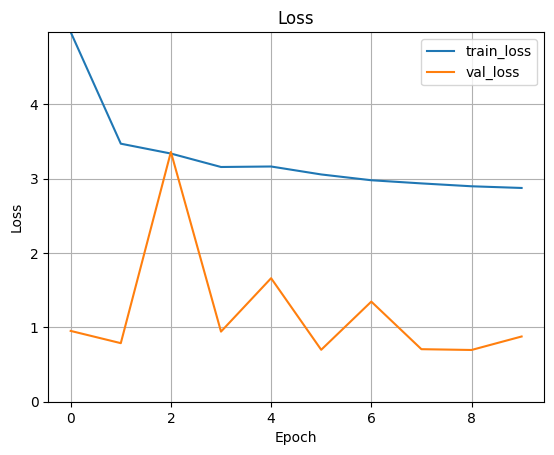

In [49]:
plot_loss(history)

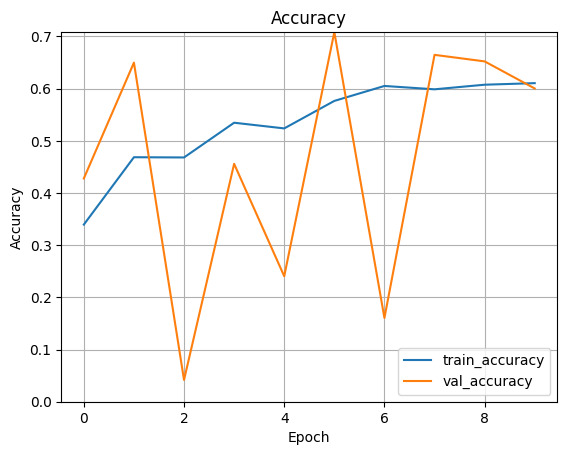

In [50]:
plot_accuracy(history)

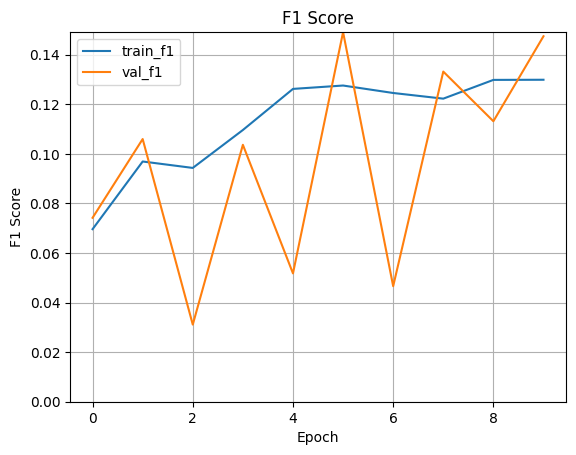

In [51]:
plot_f1(history)

**Model 2.1.1: Learning Rate = 0.0001**

In [ ]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (4,4), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Images (InputLayer)      [(None, 148, 188, 4  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_8 (Conv2D)              (None, 145, 185, 39  2535        ['Input_Images[0][0]']           
                                )                                                                 
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 71, 91, 39)  0           ['conv2d_8[0][0]']               
                                                                                           

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

In [ ]:
plot_f1(history)

**Model 2.1.2: Learning Rate = 0.01**

In [ ]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (4,4), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

In [ ]:
plot_f1(history)

**Model 2.1.3: Changing Class Weights to 1:100 Ratio**

In [ ]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (4,4), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 100,
                2: 100,
                3: 100,
                4: 100,
                5: 100,
                6: 100,
                7: 100,
                8: 100,
                9: 100,
                10: 100,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

In [ ]:
plot_f1(history)

**Model 2.1.4: Reducing Kernel Size and Stride in Initial Image CNN**

In [ ]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (2,2), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

In [ ]:
plot_f1(history)

**Model 2.1.5: Adding Another CNN and Pooling Layer to Initial Image CNN**

In [ ]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(50, (2,2), activation="relu")(input1) 
    pooling = tf.keras.layers.MaxPooling2D((2, 2), strides=1)(cnn)
    cnn = tf.keras.layers.Conv2D(39, (4,4), activation="relu")(pooling) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(resnet) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

In [ ]:
plot_f1(history)

**Model 2.1.6: Dropout Layer Added**

In [ ]:
# From previous experiments, adding layers and using ResNet-18 yielded best results 

# x: Satellite Images, 'Stop_Signs', 'Paving_historical', 'Bus_stop', 'Collisions_Historical', Road type (one hot), Zipcode (ont hot)
# y: Future collision bin

# ACCORDING TO THE PAPER, THEY DOWNSIZED THE IMAGES FIRST INTO SMALLER MATRICES 
# THEN ADDED THE STREET CHARACTERISTICS TO THE SMALLER MATRIX
# REFERENCE THE DIAGRAM ON THE PAPER

def create_cnn_model():

    # INPUT LAYERS
    input1 = tf.keras.layers.Input(shape=(148, 188, 4), name='Input_Images')
    input2 = tf.keras.layers.Input(shape=(1,1,39), name='Input_Street') 
    
    #CNN FOR IMAGE PROCESSING
    cnn = tf.keras.layers.Conv2D(39, (4,4), activation="relu")(input1) # layers = street data dimension
    pooling = tf.keras.layers.MaxPooling2D((4, 4), strides=2)(cnn)
    images = tf.keras.models.Model(inputs=input1, outputs=pooling)
    
    #ADDING STREET DATA
    #combined = tf.keras.layers.Concatenate(axis = 2)([images.output, input2])
    combined = tf.keras.layers.Add()([images.output, input2])
    
    # PAPER USES RESNET-18 FOR THE REST OF THE MODEL WITH THE COMBINED DATA
    resnet = resnet18(combined)
    
    # DROPOUT ADDED
    dropout = tf.keras.layers.Dropout(.2)
    
    output = tf.keras.layers.Dense(units=11, activation='softmax', name='output')(dropout) # units = number of classes
    
    #instantiation layer 
    cnn_model = tf.keras.models.Model(inputs=[input1, input2], outputs=output)
    
    return cnn_model

cnn_model = create_cnn_model()

cnn_model.summary()

f1 = tfa.metrics.F1Score(
    num_classes = 11,
    average = 'macro',
    threshold = None,
    name = 'f1',
    )

cnn_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics = ['accuracy', f1])

class_weight = {0: 1,
                1: 10,
                2: 10,
                3: 10,
                4: 10,
                5: 10,
                6: 10,
                7: 10,
                8: 10,
                9: 10,
                10: 10,
                # 11: 10,
               }

y = tf.keras.utils.to_categorical(y_train, num_classes=11)

history = cnn_model.fit(
    [images_mini, street_mini],
    y,
    epochs=10,
    # Suppress logging.
     verbose=1,
    # Calculate validation results on 20% of the training data.
    validation_split = 0.2,
    class_weight = class_weight
    )

In [ ]:
plot_loss(history)

In [ ]:
plot_accuracy(history)

In [ ]:
plot_f1(history)